# PA2 - Testing of Lambda Values

In [18]:
# Initial testing of the code involved lambda smoothing with lambda = 1
# The same set of code were used but the part starting in the calculation of likelihoods with lambdas were inserted inside a for loop

TP: [7328, 7294, 7377, 7400, 7417]
TN: [3713, 3834, 3853, 3841, 3824]
FP: [178, 57, 38, 50, 67]
FN: [128, 162, 79, 56, 39]

Precision: [0.9762856381561418, 0.9922459529315739, 0.9948752528658126, 0.9932885906040269, 0.9910475681453768]
Recall: [0.9828326180257511, 0.9782725321888412, 0.9894045064377682, 0.9924892703862661, 0.9947693133047211]



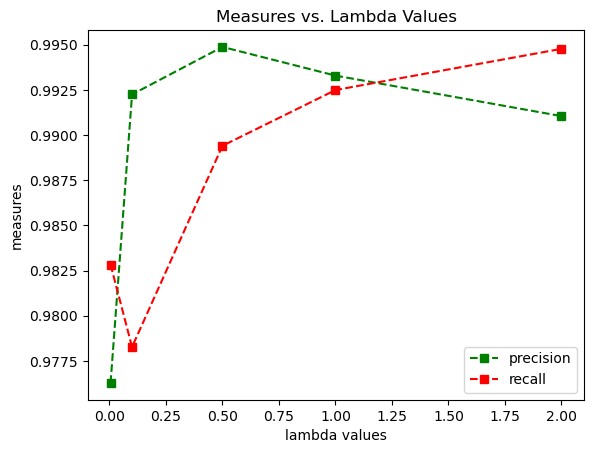

CPU times: total: 46min 58s
Wall time: 52min


In [19]:
%%time

import csv
import random
import math
import os
import matplotlib.pyplot as plt

# Generate all file paths
data_folder = r'C:\Users\W-F-BOLO\OneDrive - University of the Philippines\Documents\0_MEngAI\[1-2] AI 201\AI201_PA2_Spam_Filter_2SAY24-25\trec06p-ai201\data'

directory = [os.path.join(data_folder, f'{n:03}', f'{u:03}') for n in range(126) for u in range(300)] 
directory = directory + [os.path.join(data_folder, '126', f'{u:03}') for u in range(22)]


# Labels into a dictionary
label_dir = r'C:\Users\W-F-BOLO\OneDrive - University of the Philippines\Documents\0_MEngAI\[1-2] AI 201\AI201_PA2_Spam_Filter_2SAY24-25\trec06p-ai201\labels'
labels = {}

d = 0
with open(label_dir, newline='') as file:
    reader = csv.reader(file)
    for row in reader:
        label, filename = row[0].split()
        labels[directory[d]] = label
        d += 1


# Split data into train and test
ratio = 0.7
random.Random(1).shuffle(directory)
split_id = int(len(directory) * ratio)
train, test = directory[:split_id], directory[split_id:]

ham_counter, spam_counter = 0, 0
word_counts = {}

# Training
for file_dir in train:
    
    label = labels.get(file_dir)  
    if label == 'ham':
        ham_counter += 1
    elif label == 'spam':
        spam_counter += 1

    # Read file content
    with open(file_dir, newline='', errors='ignore') as file:
        reader = csv.reader(file)
        content = [' '.join(row) for row in reader]

    # Creating a unique list of lowered-case words from the file
    initial = ' '.join(content).replace(',', ' ').replace('.', ' ').split()
    inter = [w.lower() for w in initial]
    words = set(inter)
    
    for word in words:
        if word.isalpha():
            if word not in word_counts:
                word_counts[word] = {'ham': 0, 'spam': 0}
                word_counts[word][label] += 1
            else:
                word_counts[word][label] += 1
            
# Extract vocabulary
vocabulary = list(word_counts.keys())

# Compute Priors
priors_ham = ham_counter / len(train)
priors_spam = spam_counter / len(train)

tv = len(vocabulary)
th, ts = ham_counter, spam_counter
total = th + ts

# Compute Likelihoods with Laplace Smoothing
lamb_values = [0.005, 0.1, 0.5, 1, 2]
TP_values, TN_values, FP_values, FN_values = [], [], [], []
pre_values, rec_values = [], [] 

for i in range(len(lamb_values)):

    lamb = lamb_values[i]

    # Likelihood when found in ham or spam (in log form)
    likelihood_ham = {word: math.log((counts['ham'] + lamb) / (th + lamb * tv)) for word, counts in word_counts.items()}
    likelihood_spam = {word: math.log((counts['spam'] + lamb) / (ts + lamb * tv)) for word, counts in word_counts.items()}

    # Likelihood when not found in ham nor spam (in log form)
    likelihood_ham_neg = {word: math.log(1 - math.exp(likelihood_ham[word])) if likelihood_ham[word] < 0 else math.log(1e-10) for word in vocabulary}
    likelihood_spam_neg = {word: math.log(1 - math.exp(likelihood_spam[word])) if likelihood_spam[word] < 0 else math.log(1e-10) for word in vocabulary}
    
    # Testing
    test_class = []
    test_pred = []
    
    for file_dir in test:
    
        test_class.append(labels.get(file_dir))
        
        with open(file_dir, newline='', errors='ignore') as file:
            reader = csv.reader(file)
            content = [' '.join(row) for row in reader]

        # creating a uniqe list of lowered-case words from the test file
        initial = ' '.join(content).replace(',', ' ').replace('.', ' ').split()
        inter = [w.lower() for w in initial]
        con_spl = set(inter)
    
        value_h = math.log(priors_ham)
        value_s = math.log(priors_spam)
    
        for word in vocabulary:
            if word in con_spl:
                value_h += likelihood_ham.get(word) 
                value_s += likelihood_spam.get(word)
            else:
                value_h += likelihood_ham_neg.get(word)
                value_s += likelihood_spam_neg.get(word)
                
        h = value_h
        s = value_s
    
        if h > s:
            test_pred.append('ham')
        elif h < s:
            test_pred.append('spam')
        else:
            test_pred.append('either')
    
    
    # Initialize counters
    TP, TN, FP, FN = 0, 0, 0, 0
    
    # Count True Positives, True Negatives, False Positives, False Negatives
    for i, pred in enumerate(test_pred):
        actual = test_class[i].split()[0] 
    
        if actual == 'spam' and pred == 'spam':
            TP += 1
        elif actual == 'ham' and pred == 'ham':
            TN += 1
        elif actual == 'ham' and pred == 'spam':
            FP += 1
        elif actual == 'spam' and pred == 'ham':
            FN += 1
    
    # Avoid division by zero
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    
    TP_values.append(TP)
    TN_values.append(TN)
    FP_values.append(FP)
    FN_values.append(FN)
    pre_values.append(precision)
    rec_values.append(recall)


print(f'TP: {TP_values}\nTN: {TN_values}\nFP: {FP_values}\nFN: {FN_values}\n')
print(f'Precision: {pre_values}\nRecall: {rec_values}\n')


# Plotting the values: lambda, precision, and recall
plt.plot(lamb_values, pre_values, label = "precision", color = "green", linestyle = 'dashed', marker = 's')
plt.plot(lamb_values, rec_values, label = "recall", color = "red", linestyle = 'dashed', marker = 's')

plt.xlabel('lambda values')
plt.ylabel('measures')
plt.title('Measures vs. Lambda Values')

plt.legend()
plt.show()

# PA2 - Using the Best Lambda and the Top 200 Informative Words

In [21]:
# Started with creating the MI Calculation block of codes then proceeded with the likelihood calculations
# Utilized the training set from the previous experiment (lambda values testing)

Top 200 Informative words
i: {'ham': 6450, 'spam': 2966}; MI: 1.8451815072655546
list: {'ham': 3649, 'spam': 207}; MI: 1.8057650233031206
the: {'ham': 8294, 'spam': 8861}; MI: 1.7379259543617587
if: {'ham': 4295, 'spam': 2053}; MI: 1.6727410570605534
on: {'ham': 5872, 'spam': 4525}; MI: 1.6686865753406386
use: {'ham': 2820, 'spam': 661}; MI: 1.6547822895983901
thanks: {'ham': 2204, 'spam': 240}; MI: 1.6484278049138337
mime: {'ham': 653, 'spam': 6520}; MI: 1.646164186551799
that: {'ham': 5555, 'spam': 4462}; MI: 1.642460861870922
to: {'ham': 7911, 'spam': 9826}; MI: 1.633128377593295
of: {'ham': 7089, 'spam': 7738}; MI: 1.632971141235123
format: {'ham': 750, 'spam': 6524}; MI: 1.6320213588326309
it: {'ham': 5616, 'spam': 4834}; MI: 1.6293536723719986
there: {'ham': 2923, 'spam': 1103}; MI: 1.623260482611431
would: {'ham': 2755, 'spam': 942}; MI: 1.6222880466357674
but: {'ham': 3982, 'spam': 2413}; MI: 1.621654358113737
my: {'ham': 3089, 'spam': 1348}; MI: 1.618363549707734
university: {

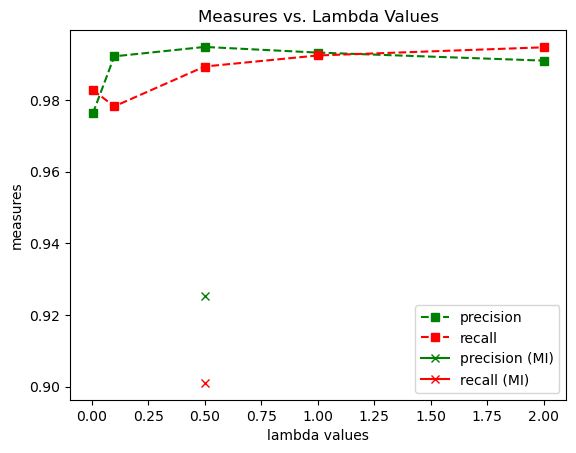

CPU times: total: 4.91 s
Wall time: 4.92 s


In [22]:
%%time

# MI Calculation
mutual_info = {}

for word, counts in word_counts.items():
    # word presence counts
    A = counts['ham']
    B = counts['spam']
    C = th - A
    D = ts - B

    # Conditional Probabilities
    P_w1_H = A/th if A > 0  else 1e-10
    P_w1_S = B/ts if B > 0  else 1e-10
    P_w0_H = C/th if C > 0  else 1e-10
    P_w0_S = D/ts if D > 0  else 1e-10

    # Marginal Probabilities
    P_w1 = (A + B) / total if (A+B) > 0 else 1e-10
    P_w0 = (C + D) / total if (C+D) > 0 else 1e-10
    P_H = priors_ham
    P_S = priors_spam

    # MI calculation proper
    MI = P_w1_H * math.log(P_w1_H / (P_w1 * P_H)) + P_w0_H * math.log(P_w0_H / (P_w0 * P_H)) + P_w1_S * math.log(P_w1_S / (P_w1 * P_S)) + P_w0_S * math.log(P_w0_S / (P_w0 * P_S))

    mutual_info[word] = MI

# Finding the top 200 informative words to comprise the new vocabulary
sorted_mi = {w: m for w, m in sorted(mutual_info.items(), key=lambda item: item[1], reverse=True)}
vocabulary = {w: m for i, (w, m) in enumerate(sorted_mi.items()) if i < 200}
new = {key: word_counts[key] for key in vocabulary}
word_counts = new

tv = len(vocabulary)

print("Top 200 Informative words")
for word, count in word_counts.items():
    print(f'{word}: {count}; MI: {vocabulary.get(word)}')


# Using the best lambda from earlier experiment
lamb = 0.5

# Likelihood when found in ham or spam (in log form)
likelihood_ham = {word: math.log((counts["ham"] + lamb) / (th + lamb * tv)) for word, counts in word_counts.items()}
likelihood_spam = {word: math.log((counts["spam"] + lamb) / (ts + lamb * tv)) for word, counts in word_counts.items()}

# Likelihood when not found in ham nor spam (in log form)
likelihood_ham_neg = {word: math.log(1 - math.exp(likelihood_ham[word])) if likelihood_ham[word] < 0 else math.log(1e-10) for word in vocabulary}
likelihood_spam_neg = {word: math.log(1 - math.exp(likelihood_spam[word])) if likelihood_spam[word] < 0 else math.log(1e-10) for word in vocabulary}


# Testing
test_class = []
test_pred = []

for file_dir in test:

    test_class.append(labels.get(file_dir))
    
    with open(file_dir, newline='', errors='ignore') as file:
        reader = csv.reader(file)
        content = [' '.join(row) for row in reader]

    # creating a uniqe list of lowered-case words from the test file
    initial = ' '.join(content).replace(',', ' ').replace('.', ' ').split()
    inter = [w.lower() for w in initial]
    con_spl = set(inter)

    value_h = math.log(priors_ham)
    value_s = math.log(priors_spam)

    for word in vocabulary:
        if word in con_spl:
            value_h += likelihood_ham.get(word) 
            value_s += likelihood_spam.get(word)
        else:
            value_h += likelihood_ham_neg.get(word)
            value_s += likelihood_spam_neg.get(word)
            
    h = value_h
    s = value_s

    if h > s:
        test_pred.append('ham')
    elif h < s:
        test_pred.append('spam')
    else:
        test_pred.append('either')


# Initialize counters
TP, TN, FP, FN = 0, 0, 0, 0

# Count True Positives, True Negatives, False Positives, False Negatives
for i, pred in enumerate(test_pred):
    actual = test_class[i].split()[0] 

    if actual == 'spam' and pred == 'spam':
        TP += 1
    elif actual == 'ham' and pred == 'ham':
        TN += 1
    elif actual == 'ham' and pred == 'spam':
        FP += 1
    elif actual == 'spam' and pred == 'ham':
        FN += 1

# Avoid division by zero
precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0

print(f'TP: {TP}\nTN: {TN}\nFP: {FP}\nFN: {FN}\n')
print(f'Precision: {precision}\nRecall: {recall}\n')

# Plotting copy of the plot from the previous experiment, adding this new one

plt.plot(lamb_values, pre_values, label = "precision", color = "green", linestyle = 'dashed', marker = 's')
plt.plot(lamb_values, rec_values, label = "recall", color = "red", linestyle = 'dashed', marker = 's')
plt.plot(0.5, precision, label = "precision (MI)", color = "green", marker = 'x')
plt.plot(0.5, recall, label = "recall (MI)", color = "red", marker = 'x')

plt.xlabel('lambda values')
plt.ylabel('measures')
plt.title('Measures vs. Lambda Values')

plt.legend()
plt.show()

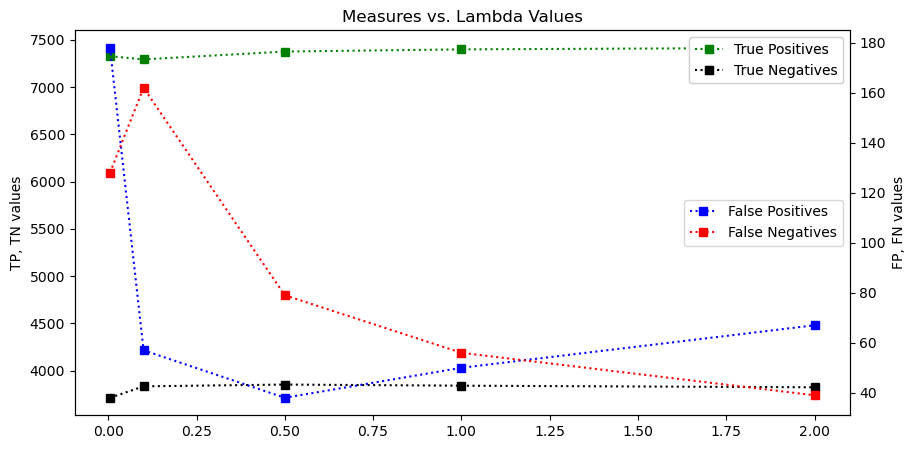

In [23]:
# Plotting the values: lambda, TP, TN, FP, FN

fig, ax = plt.subplots(figsize = (10,5))
ax2 = ax.twinx()

ax.plot(lamb_values, TP_values, label = "True Positives", color = "green", linestyle = 'dotted', marker = 's')
ax.plot(lamb_values, TN_values, label = "True Negatives", color = "black", linestyle = 'dotted', marker = 's')
ax2.plot(lamb_values, FP_values, label = "False Positives", color = "blue", linestyle = 'dotted', marker = 's')
ax2.plot(lamb_values, FN_values, label = "False Negatives", color = "red", linestyle = 'dotted', marker = 's')

plt.xlabel('lambda values')
ax.set_ylabel('TP, TN values')
ax2.set_ylabel('FP, FN values')
plt.title('Measures vs. Lambda Values')

plt.legend(loc='center right')
ax.add_artist(ax.legend(loc='upper right'))
plt.show()